# Capstone Project: Region of Boom

## Table of Contents
- [Capstone Project: Region of Boom¶](#Capstone-Project:-Region-of-Boom)
    - [Table of Contents¶](#Table-of-Contents)
    - [Information about the Data](#Information-about-the-Data)
        - [Why We Looked for Better Data](#Why-We-Looked-for-Better-Data)
        - [Our New Data: Building Permit Surveys](#Our-New-Data:-Building-Permit-Surveys)
    - [Wrangle](#Wrangle)
        - [Acquire](#Acquire)
            - [Functions](#Functions)
            - [Data Summary & Preliminary Exploration](#Data-Summary-&-Preliminary-Exploration)
        - [Prepare](#Prepare)
            - [Function](#Function)
            - [Returning to Preliminary Exploration](#Returning-to-Preliminary-Exploration)
    - [Preprocessing](#Preprocessing)

In [1]:
# import python libraries
import numpy as np
import pandas as pd

import re

import os.path
from os import path

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing_permits as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_columns", None)
plt.rc("figure", figsize=(16, 8))
sns.set_palette("colorblind")

---
## Information about the Data

The initial iteration of this project was performed using the United States Department of Housing and Urban Development (HUD) Federal Housing Administration (FHA) multifamily loan production data. After reaching an minimum viable product (MVP) with the aforementioned data, we as a team felt that the data we had was insufficient to adequately answer the research question that spawned our capstone project:

> How many high-density, multifamily structures are being built in the U.S. everyday?

Upon reaching an MVP the FHA data, we looked for a larger dataset to continue working on our project. The work done on the dataset we aquired for our second iteration, which we believe is more complete, is below. Our initial project can be found [here](https://nbviewer.jupyter.org/github/hud-capstone/capstone/blob/master/mvp_notebook.ipynb).

### Why We Looked for Better Data

For our capstone, we wanted to explore and model multifamily housing *construction* in the U.S. over time. The dataset we initially found was information on FHA multifamily mortgages over the past 15 years. As we explored the data, we recognized some problems that needed to be overcome:

1. Not all construction that happens in the U.S. uses a FHA backed mortgage. As a result, we could not gain any insights on construction behavior in the private sector using the FHA data.
2. 80% of the dataset was refinanced mortgages. There are many reasons to refinance a loan, but unpacking which of these refinances indicated refinancing a *construction* loan was out-of-scope for this project ([read more here](https://www.reonomy.com/blog/post/commercial-loan-refinance)). Ultimately, the activity that was of interest to our stakeholder was a minority of the dataset.  
3. After reshaping our data to make a single observation (a `city_state_year`), we were left with a small number of observations that provided us with continuous information for the time period. While imputation with zero values was a reasonable solution for observations lacking data, this created a new set of problems.
4. When imputing with zeros, our continuous variables ended up behaving like discrete variables because we had so many instances of just one or zero mortgages for a `city_state_year` observation.
    
### Our New Data: Building Permit Surveys

Using the United States Census Bureau Building Permit Survey data, we were able to gain more insights and create value for our stakeholder.

[United States Census Bureau Building Permits Survey](https://www.census.gov/construction/bps/): The main webpage where the data was sourced

[ASCII files by State, Metropolitan Statistical Area (MSA), County or Place](https://www2.census.gov/econ/bps/): The comma-separated text files aggregated based on various geographical areas

[MSA Folder](https://www2.census.gov/econ/bps/Metro/): We used data on the Metropolitan Statistical Area level of granularity

[ASCII MSA Documentation](https://www2.census.gov/econ/bps/Documentation/msaasc.pdf): Documentation of the original features found in the resultant DataFrame from `acquire_building_permits` function

Our data science pipeline and conclusions are below. Enjoy!

---
## Wrangle

All functions are stored in `wrangle.py`.

### Acquire

#### Functions
- `acquire_building_permits` - This function acquires MSA building permit survey data from the U.S. Census Bureau
- `rename_building_permit_columns` - Renames columns from the original text files storing the data
    - **Note**: This function is called within `acquire_building_permits`

In [3]:
# storing data in df variable
df = wr.acquire_building_permits()

#### Data Summary & Preliminary Exploration

In [4]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.
Currently, each observation is the estimated and reported annual building permit survey data by metropolitan area.
We will need to reshape our data for modeling.""")
df

Our DataFrame contains 8,382 observations and 29 features.
Currently, each observation is the estimated and reported annual building permit survey data by metropolitan area.
We will need to reshape our data for modeling.


,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,two_units_value_est,three_to_four_units_bldgs_est,three_to_four_units_units_est,three_to_four_units_value_est,five_or_more_units_bldgs_est,five_or_more_units_units_est,five_or_more_units_value_est,one_unit_bldgs_rep,one_unit_units_rep,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,2019,104.0,10580.0,True,Albany-Schenectady-Troy NY,1120.0,1120.0,309397.0,20.0,40.0,7644.0,12.0,45.0,6074.0,48.0,665.0,60456.0,984.0,984.0,268946.0,18.0,36.0,6544.0,12.0,45.0,6074.0,34.0,580.0,56469.0
1,2019,430.0,48260.0,False,Weirton-Steubenville WV-OH,25.0,25.0,5782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,5782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,999.0,10180.0,False,Abilene TX,354.0,354.0,72824.0,8.0,16.0,2093.0,0.0,0.0,0.0,0.0,0.0,0.0,353.0,353.0,72596.0,8.0,16.0,2093.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019,566.0,49660.0,False,Youngstown-Warren-Boardman OH-PA,323.0,323.0,73182.0,2.0,4.0,407.0,1.0,3.0,467.0,0.0,0.0,0.0,234.0,234.0,50054.0,2.0,4.0,407.0,1.0,3.0,467.0,0.0,0.0,0.0
4,2019,558.0,48700.0,False,Williamsport PA,66.0,66.0,16215.0,6.0,12.0,1610.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,49.0,12095.0,6.0,12.0,1610.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8377,1997,6240.0,9999.0,False,Pine Bluff AR MSA,100.0,100.0,4638.0,10.0,20.0,405.0,0.0,0.0,0.0,1.0,96.0,1826.0,100.0,100.0,4638.0,10.0,20.0,405.0,0.0,0.0,0.0,1.0,96.0,1826.0
8378,1997,6280.0,9999.0,False,Pittsburgh PA MSA,4432.0,4432.0,551173.0,66.0,132.0,9580.0,52.0,194.0,12291.0,102.0,1306.0,65021.0,3705.0,3705.0,481092.0,60.0,120.0,9251.0,45.0,173.0,12002.0,81.0,1111.0,56757.0
8379,1997,6320.0,9999.0,False,Pittsfield MA MSA,97.0,97.0,11578.0,3.0,6.0,342.0,0.0,0.0,0.0,1.0,120.0,5750.0,80.0,80.0,9447.0,3.0,6.0,342.0,0.0,0.0,0.0,1.0,120.0,5750.0
8380,1997,6340.0,9999.0,False,Pocatello ID MSA,263.0,263.0,23778.0,8.0,16.0,870.0,20.0,80.0,3630.0,2.0,14.0,543.0,263.0,263.0,23778.0,8.0,16.0,870.0,20.0,80.0,3630.0,2.0,14.0,543.0


**Let's get some high-level information on our data**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8382 entries, 0 to 8381
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   survey_date                    8382 non-null   int64  
 1   csa_code                       8382 non-null   float64
 2   cbsa_code                      8382 non-null   float64
 3   moncov                         8382 non-null   bool   
 4   cbsa_name                      8382 non-null   object 
 5   one_unit_bldgs_est             8382 non-null   float64
 6   one_unit_units_est             8382 non-null   float64
 7   one_unit_value_est             8382 non-null   float64
 8   two_units_bldgs_est            8382 non-null   float64
 9   two_units_units_est            8382 non-null   float64
 10  two_units_value_est            8382 non-null   float64
 11  three_to_four_units_bldgs_est  8382 non-null   float64
 12  three_to_four_units_units_est  8382 non-null   f

---
**Let's take a look at the distribution of our data**

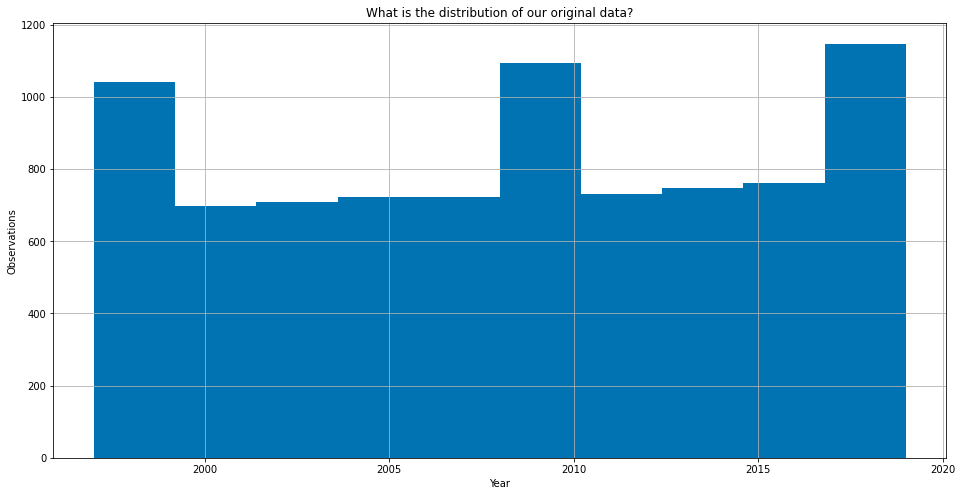

In [6]:
df.survey_date.hist()
plt.title("What is the distribution of our original data?")
plt.xlabel("Year")
plt.ylabel("Observations")
plt.show()

**Takeaway**: Looks like our data is relatively uniformly distributed with some outlier years.

---

**Let's take a look at the top 20 metro areas**

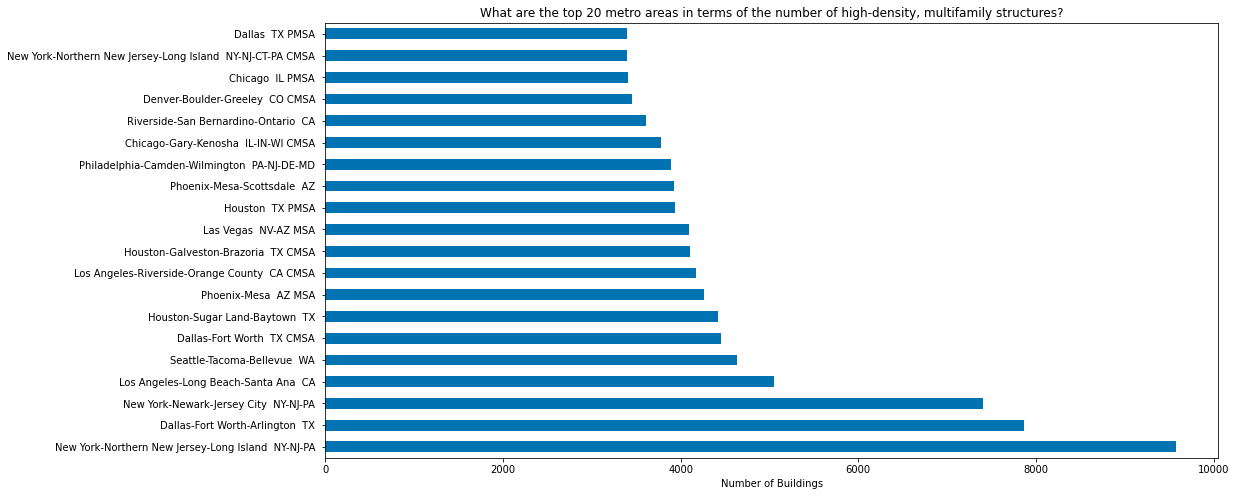

In [7]:
df.groupby("cbsa_name").five_or_more_units_bldgs_est.sum().sort_values(ascending=False
).nlargest(20).plot(kind="barh")
plt.title("What are the top 20 metro areas in terms of the number of high-density, multifamily structures?")
plt.xlabel("Number of Buildings")
plt.ylabel("")
plt.show()

**Takeaway**: Not surprisingly, the NYC metro area tops the charts. Another consideration is the fact that we will need to standardize these metro area names to get unique metro observations. Let's handle that now before we continue on in our exploration so that our insights are more valuable.

### Prepare

#### Function
- `prep_building_permits` - This function creates some standardized the `major_city` and `major_state` features out of the `cbsa_name` feature from our inital DataFrame. Additionally, this function groups the `major_city`, `major_state`, and `survey_date` features together and summarizes all other quantitative features in the DataFrame.

In [8]:
df = wr.prep_building_permits(df)

In [9]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df

Our DataFrame contains 8,269 observations and 30 features.


,major_city,major_state,survey_date,csa_code,cbsa_code,moncov,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,two_units_value_est,three_to_four_units_bldgs_est,three_to_four_units_units_est,three_to_four_units_value_est,five_or_more_units_bldgs_est,five_or_more_units_units_est,five_or_more_units_value_est,one_unit_bldgs_rep,one_unit_units_rep,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,Abilene,TX,1997,40.0,9999.0,False,215.0,215.0,25825.0,0.0,0.0,0.0,1.0,3.0,125.0,0.0,0.0,0.0,215.0,215.0,25825.0,0.0,0.0,0.0,1.0,3.0,125.0,0.0,0.0,0.0
1,Abilene,TX,1998,40.0,9999.0,False,250.0,250.0,32745.0,2.0,4.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,250.0,32745.0,2.0,4.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Abilene,TX,1999,40.0,9999.0,False,179.0,179.0,25372.0,3.0,6.0,382.0,0.0,0.0,0.0,0.0,0.0,0.0,179.0,179.0,25372.0,3.0,6.0,382.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abilene,TX,2000,40.0,9999.0,False,164.0,164.0,22306.0,9.0,18.0,1140.0,0.0,0.0,0.0,15.0,192.0,10200.0,164.0,164.0,22306.0,9.0,18.0,1140.0,0.0,0.0,0.0,15.0,192.0,10200.0
4,Abilene,TX,2001,40.0,9999.0,False,172.0,172.0,25539.0,28.0,56.0,3286.0,41.0,164.0,7631.0,13.0,192.0,6333.0,172.0,172.0,25539.0,28.0,56.0,3286.0,41.0,164.0,7631.0,13.0,192.0,6333.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8264,Yuma,AZ,2015,999.0,49740.0,False,765.0,765.0,117198.0,0.0,0.0,0.0,1.0,3.0,106.0,0.0,0.0,0.0,765.0,765.0,117198.0,0.0,0.0,0.0,1.0,3.0,106.0,0.0,0.0,0.0
8265,Yuma,AZ,2016,999.0,49740.0,False,890.0,890.0,137493.0,0.0,0.0,0.0,2.0,7.0,712.0,0.0,0.0,0.0,824.0,824.0,131881.0,0.0,0.0,0.0,2.0,7.0,712.0,0.0,0.0,0.0
8266,Yuma,AZ,2017,999.0,49740.0,False,1005.0,1005.0,163723.0,2.0,4.0,245.0,6.0,24.0,3118.0,8.0,68.0,8986.0,993.0,993.0,161953.0,1.0,2.0,245.0,6.0,24.0,3118.0,8.0,68.0,8986.0
8267,Yuma,AZ,2018,999.0,49740.0,False,1011.0,1011.0,160289.0,2.0,4.0,262.0,0.0,0.0,0.0,0.0,0.0,0.0,1011.0,1011.0,160289.0,2.0,4.0,262.0,0.0,0.0,0.0,0.0,0.0,0.0


**Takeaway**: Now we have unique city, state, year observations for our data! Let's revisit that horizontal bar plot we saw earlier.

---

#### Returning to Preliminary Exploration

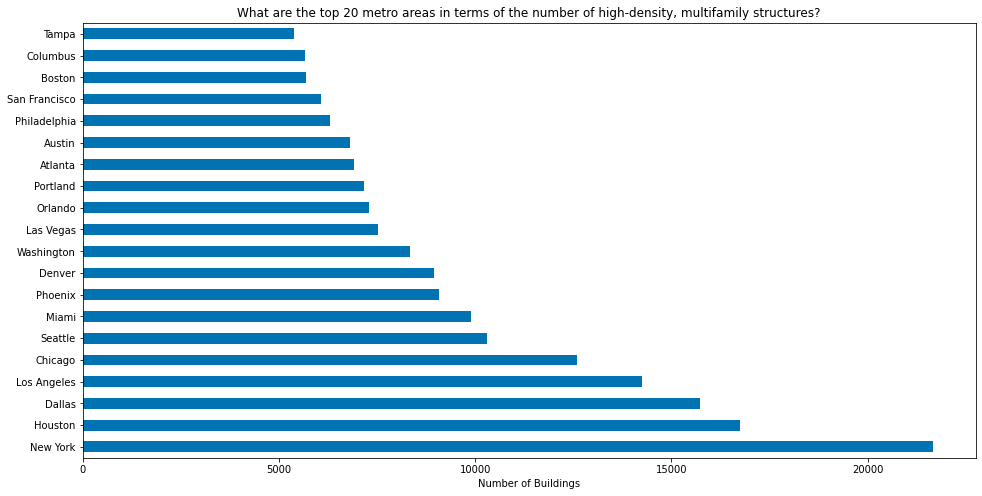

In [10]:
df.groupby("major_city").five_or_more_units_bldgs_est.sum().nlargest(20).plot(kind="barh")
plt.title("What are the top 20 metro areas in terms of the number of high-density, multifamily structures?")
plt.xlabel("Number of Buildings")
plt.ylabel("")
plt.show()

**Takeaways**: Much better! Looks like NYC is still top dog followed by Houston, Dallas, and LA.

---
**Let's peak at the distribution of the estimated high-density, multifamily building valuation**

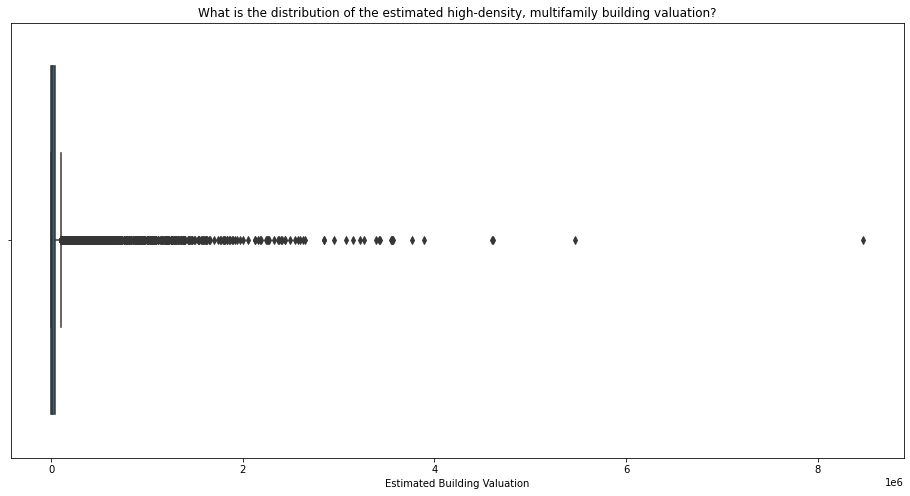

In [11]:
sns.boxplot(df.five_or_more_units_value_est)
plt.title("What is the distribution of the estimated high-density, multifamily building valuation?")
plt.xlabel("Estimated Building Valuation")
plt.show()

**Takeaways**: Wow! Our data is very right-skewed with a lot of upper outliers. Unfortunately, we cannot afford to remove the outliers in this dataset since we need as complete of a picture as possible to gain insights into the multifamily housing market. This will make statistical testing difficult.

---

Now that we have a decent grasp of our data, we need to restucture the dataset into a useable format for exploration and modeling. Let's do some preprocessing!

---
## Preprocessing

In order to get our data into a useable format for meaningful exploration and subsequent modeling we decided to group the data by city and state for each year to get unique observations. Below is a brief summary of the functions found in the `preprocessing_permits.py` script which help to restructure our data into a useable format:

**Create Model DataFrame**
- `get_permits_model_df`: This function wrangles the data, selects only the features of relevance to our research (high-density, multifamily metrics), and gives those features more meaningful names.

**Feature Engineering**
- `calculate_avg_units_per_bldg`: This function calcuates the average number of units per building for an observation by dividing the total number of units by the total number of buildings.
- `calculate_value_per_bldg`: This function calcuates the average valuation per building for an observation by dividing the total valuation by the total number of buildings.
- `calculate_value_per_unit`: This function calcuates the average valuation per unit for an observation by dividing the total valuation by the total number of units.
- `calculate_city_state_high_density_bldgs_delta_pct`: This function calcuates the growth rate based on the total number of buildings for unique observations.
- `calculate_city_state_high_density_units_delta_pct`: This function calcuates the growth rate based on the total number of units for unique observations.
- `calculate_city_state_high_density_value_delta_pct`: This function calcuates the growth rate based on total valuation for unique observations.
- `calculate_evolution_index`: This function calculates the evolution index. Breifly, the evolution index is the measure of an observation's relative performance in terms of a growth rate compared to that of the total market growth year-over-year.
- `add_new_features`: This function calls all of the above feature engineering functions.

**Clustering**
- `create_clusters`: This function creates clusters using average units per building & evolution index.

**Label, Split, & Scale**
- `filter_top_cities_building_permits`: This function transforms the DataFrame such that the output returns cities with only continuously reported data, and cities where the observation had at least one high-density building for every year.
- `labeling_future_data`: This function labels a city_state_year observation as a market that should be entered based on the future two year growth rate of that observation.
- `split_data`: This function splits our data into train, validate, and test.
- `return_values`: This is a helper function used to update the scaled arrays and transform them into usable DataFrames (called within `min_max_scaler`).
- `min_max_scaler`: This is a helper function that scales the data.
- `prep_data_for_modeling_permits`: This function masks our DataFrame such that there are no null values for the relevant modeling features, creates an `observation_id` feature using the `city`, `state`, and `year` features, calls `split_data`, and calls `min_max_scaler`.

**Mother Function**
- `permits_preprocessing_mother_function`: This function wraps all of the functions documented here into one simple function.

---

Now let's use our functions to create labels, explore, and model.

---

In [12]:
df = pr.get_permits_model_df()
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 8,269 observations & 6 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value
0,Abilene,TX,1997,0.0,0.0,0.0
1,Abilene,TX,1998,0.0,0.0,0.0
2,Abilene,TX,1999,0.0,0.0,0.0
3,Abilene,TX,2000,15.0,192.0,10200000.0
4,Abilene,TX,2001,13.0,192.0,6333000.0


Now our DataFrame contains only unique combinations of the `city`, `state`, and `year` features with summarized metrics on estimated high-denisty, multifamily housing. However, we need some more meaningful features. Let's call our trusty `add_new_features` function on our `df` variable to help us out.

In [13]:
df = pr.add_new_features(df)
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 8,269 observations & 15 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei
0,Abilene,TX,1997,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.054924e+10,NaN,NaN
1,Abilene,TX,1998,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.529787e+10,0.231085,NaN
2,Abilene,TX,1999,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.609590e+10,0.031545,NaN
3,Abilene,TX,2000,15.0,192.0,10200000.0,12.800000,680000.000000,53125.000,inf,inf,inf,2.742204e+10,0.050818,inf
4,Abilene,TX,2001,13.0,192.0,6333000.0,14.769231,487153.846154,32984.375,-0.133333,0.0,-0.379118,2.913103e+10,0.062322,0.584458


That's better! We have some very interesting feautures to both explore and help us create labels for our data.

---
### Creating Labels

Here we will document the various methods used to create labels for our data. First, we will explore the two-year growth rate labels.

#### Two-Year Growth Rate

Real estate development is a long-term game. In order to identify potentially lucrative future markets for our stakeholder, we need label our data such that we are predicting the growth rate of a market two-years from now.

Before we get to the calculation, we need to filter our data such that we are only considering cities with 23 *consecutive* years worth of high-density, multifamily housing construction.

In [14]:
df = pr.filter_top_cities_building_permits(df)
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 2,990 observations & 16 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY


This function is crucial for the accurate acessment of our data! We went from 8,000 observations to just under 3,000 when only considering cities with 23 consecutive years worth of high-density, multifamily housing construction.

Now we can press on with the two-year growth rate calculation.

In [15]:
df = pr.labeling_future_data(df)
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 2,990 observations & 21 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,0.300000,0.370041,False
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,-0.468085,-0.702574,False
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.300000,0.370041,0.435897,0.002124,False
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,-0.468085,-0.702574,0.880000,0.837198,False
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,0.435897,0.002124,-0.214286,0.539167,False


After calling `labeling_future_data` on our DataFrame, we gain some interesting features and a label derived from those features. Essentially, the `should_enter` feature labels our observations as markets to enter or not. A market qualifies as one to enter if the projected growth rate of either the quantity or valuation of high-density, multifamily structures exceeds the third quantile plus 1.5 times the interquartile range (Q3 + (IQR * 1.5)).

**Hypothesis Testing with `should_enter`**

$H_0$: The mean valuation of high-density, multifamily structures for markets labeled to enter is the same as the population

$H_a$: The mean valuation of high-density, multifamily structures for markets labeled to enter is different from the population

In [16]:
alpha = .01

enter = df[df.should_enter == True].total_high_density_value

tstat, pvalue = stats.ttest_ind(enter, df.total_high_density_value.mean())

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = nan
  p-value = nan

Fail to reject null hypothesis


**Takeawaay**: We fail to reject the null hypothesis. The mean valuation of high-density, multifamily structures for markets labeled to enter is not statistically different from the population. There may be other features that we uncover as drivers of whether a market is labeled to enter or not. For now, let's take a look at a quick visualization to demonstrate the statistical test we just conducted.

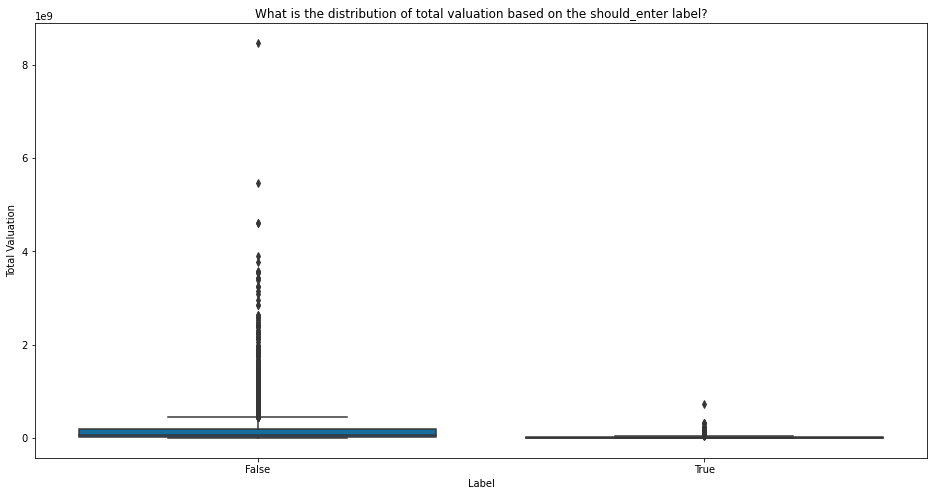

In [17]:
sns.boxplot(data=df, x="should_enter", y="total_high_density_value")
plt.title("What is the distribution of total valuation based on the should_enter label?")
plt.xlabel("Label")
plt.ylabel("Total Valuation")
plt.show()

**Takeaway**: If anything, this visual shows us that the *False* label in the should_enter feature may have a statically different mean from the population.

---

In [ ]:
# plt.figure(figsize=(14,4))
# sns.boxplot(model_df.label_quantity_of_mortgages_pop_2y)

In [ ]:
# plt.figure(figsize=(14,4))
# sns.boxplot(model_df.label_total_mortgage_volume_pop_2y, color='green')

In [ ]:
# sns.scatterplot(x='label_total_mortgage_volume_pop_2y', y='label_quantity_of_mortgages_pop_2y', data=model_df, hue='should_enter')
# plt.title("Scatterplot Visualizing Markets to Enter")
# plt.xlabel("")
# plt.ylabel("")

Next, we will do some clustering to create some labels.

---

#### Clustering

---

In [ ]:
df = pr.permits_preprocessing_mother_function()
print(f"""Our modeling DataFrame now contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Now that we have some useful labels, let's explore our data.

---

# Exploration

---

# Modeling

We will be using classification algorithms to predict what markets will be hot as of 2020/2021. This will help us create recommendations for the future, so that we know what market's will be worth investing resources and labor in, and what martek's are worth ignoring.

We will be likely using the following features for modeling:

```python
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
```

Our target variable (the variable we are trying to predict, will be:

```python
label_feature = "should_enter"
```

In this case, our positive case will be `should_enter_market`. 


When looking at our confusion matrix, and all of it's possible outcomes, it would likely look as follows:

| Matrix | Actual Positive | Actual Negative |
|--------|-----------------|-----------------|
| Predicted Positive | `enter_market` | predicted `not_enter_market`, but really it was a hot market and a missed opportunity | 
| Predicted Negative | predicted `enter_market`, but really it was a cold market, and not worth investing | `not_enter_market`


Traditionally, for a project like this one, we would have focus on reducing the number of `False_Positives`, because it would be far more expensive to the stakeholder if we predicted a city was going to be hot, they spend time and money, and their investment is not returned. However, because TestFit's business strategy and software deployment are all done online, with very little investment needed for traveling. This means that actually investing in a city is not costly at all. As such, we will optimize our models to reduce the number of `False_Negtives`, because we want to make sure we are not missing any potential markets that can be considered `hot markets` in 2020 and 2021.

Given that we have a low number of `positive` labels in our data, we will have to do something called **Oversampling**. This is a practice use in the field to basically help the predictive model by calling attention to the postiive labels and their patterns. We will create duplicate positive values, so that the model becomes more effective at predicting these values.

### Preprocessing

We want to get the data from zero, as to reduce the risk of any information spillage.

In [ ]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = preprocessing_main_function(features_for_modeling, label_feature)

This is how the data will look like before modeling:

In [ ]:
train_scaled

# Decision Tree

In [ ]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = preprocessing_main_function(features_for_modeling, label_feature)

In [ ]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})

In [ ]:
for i in range(1, 20):
    clf, y_pred = model.run_clf(train_scaled, y_train, i)
    score = clf.score(train_scaled, y_train)
    validate_score = clf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

In [ ]:
clf, y_pred = model.run_clf(train_scaled, y_train, 4)
predictions["decision_tree"] = y_pred

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

In [ ]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == train_scaled.shape[1])
coef = clf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

In [ ]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, it seems that when it comes to decision tree, the `evolution_index` is actually the most indicative feature, along side the change in number of mortgage's approved. The total `quantity_of_mortgages_pop` doesn't seem to be as influencial in the predictions.

# Random Forest

In [ ]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = preprocessing_main_function(features_for_modeling, label_feature)

In [ ]:
for i in range(1, 20):
    rf, y_pred = model.run_rf(train_scaled, y_train, 1, i)
    score = rf.score(train_scaled, y_train)
    validate_score = rf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

In [ ]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)
predictions["random_forest"] = y_pred

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

In [ ]:
coef = rf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

In [ ]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, for the random_forest model, the delta of the number of loans approved by city where the most important or influencial indicator of whether a city would be `a hot martket` or not. The evolution index was the second most influencial feature. Again, the total `quantity_of_morgages_pop` was the least influencial feature.

# KNN

In [ ]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = preprocessing_main_function(features_for_modeling, label_feature)

In [ ]:
for i in range(1, 20):
    knn, y_pred = model.run_knn(train_scaled, y_train, i)
    score = knn.score(train_scaled, y_train)
    validate_score = knn.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

In [ ]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)
predictions["knn"] = y_pred

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

In [ ]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

In [ ]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["recall"]:.2f}')

In [ ]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["precision"]:.2f}')

## Conclusion:

Overall, we see that because we have optimized for *recall*, the accuracy scores are a bit lower than expected. However, our recall scores are really good. We will choose the KNN model as the most effective model, given that it consistently achieved the best scores (for accuracy, recall and precision). 

# Evaluate

In [ ]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)

In [ ]:
y_pred = rf.predict(test_scaled)

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

---

In [ ]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)

In [ ]:
y_pred = knn.predict(test_scaled)

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

----

# Prediction

In [ ]:
df = pr.get_model_df()
df = pr.add_new_features(df)
df = pr.filter_top_cities(df)

In [ ]:
df.head()

In [ ]:
features_for_predicting = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]

In [ ]:
predictions = df[(df.year == 2020) | (df.year == 2019)].groupby("city_state")[features_for_predicting].mean()
predictions

In [ ]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [ ]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [ ]:
predictions["label"] = rf.predict(predictions_scaled)

In [ ]:
predictions

In [ ]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [ ]:
predictions = predictions.reset_index()

In [ ]:
predictions["city"] = city

predictions["state"] = state

In [ ]:
predictions

In [ ]:
predictions[predictions.label == True]

In [ ]:
predictions.to_csv("predictions.csv")

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()